# **STEP 5**

The final component of this project is testing the model that was trained. This involves loading test images and predicting the class of that image from the model designed. Testing the model requires the following steps:

• Data processing of test images to convert the images to the format of that of the input data utilized for the model trained. Use the image package from keras preprocessing to load the image, convert the image to an array, and normalize it by dividing the image by 255.

• Since this is a multi-class classification problem and the final model layer uses the softmax activation function, you would need to find the maximum probability from the model’s prediction.

In [9]:
# Import libraries and define device
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

In [7]:
# Redefining model from Step 2

class DeeperCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeeperCNN, self).__init__()

# 1st Convolutional Layer using Conv2D
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) # max pooling layer to downsample

# 2nd Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.5) # dropout for regularization/reduce overfit

# 3rd Convolutional Layer Third block: complex feature detection
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.2) # set 20% of features to zero during training; further reduce overfit

 # Fully Connected (Dense) layers
        self.fc1 = nn.Linear(128 * 16 * 16, 144)  # flatten input for dense layer
        self.dropout4 = nn.Dropout(0.5) # prevent co-adaptation of neurons before output
        self.fc2 = nn.Linear(144, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x))) # 1st Conv, ReLU, 1st Pool
        x = self.pool2(torch.relu(self.conv2(x))) # 2nd Conv, ReLU, 2nd Pool
        x = self.dropout2(x) # Block 2 Dropout
        x = self.pool3(torch.relu(self.conv3(x))) # 3rd Conv, ReLU, 3rd Pool
        x = self.dropout3(x) # Block 3 Dropout
        x = x.view(x.size(0),-1) # Flatten for dense input
        x = torch.relu(self.fc1(x)) # Dense layer ReLU
        x = self.dropout4(x) # Final Dropout
        x = self.fc2(x) # Output layer, no activation, for CrossEntropyLoss
        return x

model = DeeperCNN(num_classes=3)
model.load_state_dict(torch.load('p2_DCNN_Model.pt', map_location=device))
model.to(device)
model.eval()

DeeperCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32768, out_features=144, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=144, out_features=3, bias=True)
)

In [18]:
# Load test images from given data folder
test_info = [
    {
        'img_path': r'C:\Users\shiva\OneDrive\Desktop\AER850\AER850_Project2_ShivamPathak\data\test\crack\test_crack.jpg',
        'true_label': 'crack'
    },
    {
        'img_path': r'C:\Users\shiva\OneDrive\Desktop\AER850\AER850_Project2_ShivamPathak\data\test\missing-head\test_missinghead.jpg',
        'true_label': 'missing-head'
    },
    {
        'img_path': r'C:\Users\shiva\OneDrive\Desktop\AER850\AER850_Project2_ShivamPathak\data\test\paint-off\test_paintoff.jpg',
        'true_label': 'paint-off'
    }]

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

class_names = ['crack','missing-head','paint-off']

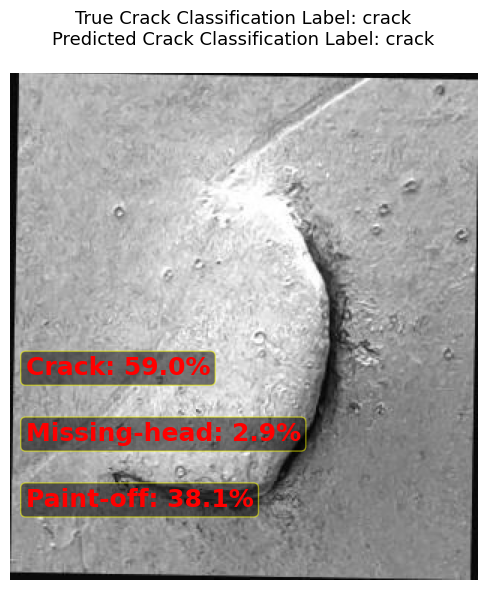

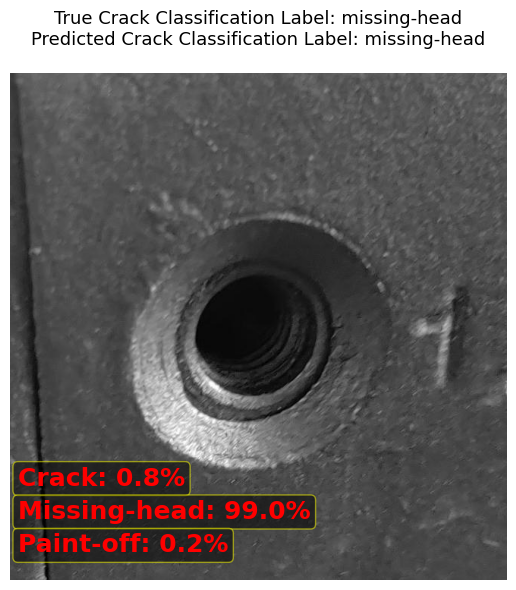

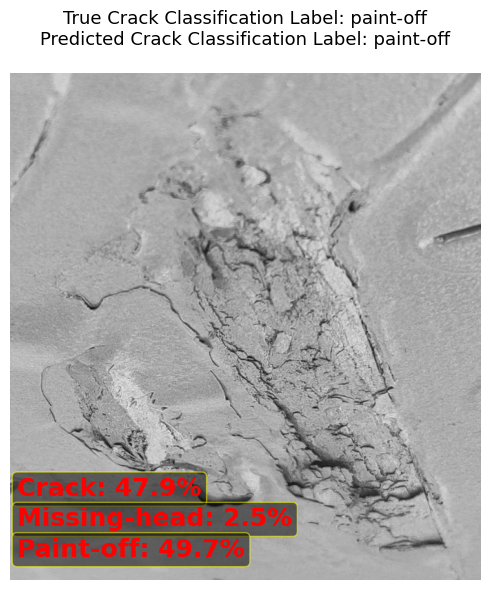

In [37]:
for info in test_info:
    img_path = info['img_path']
    true_label = info['true_label']

    # Load image and preprocess
    img = Image.open(img_path).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)

    # Inference/prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1).cpu().numpy()[0]
        predicted_index = np.argmax(probs)
        predicted_label = class_names[predicted_index]

    # Plot with prediction overlay
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis('off')

    # Title showing true and predicted labels
    plt.title(
        f"True Crack Classification Label: {true_label}\n"
        f"Predicted Crack Classification Label: {predicted_label}",
        fontsize=13, pad=20
    )

    # Overlay probabilities on image
    start_y = img.height - 150
    line_gap = 44

    for i, name in enumerate(class_names):
        plt.text(
        10,
        start_y + i * line_gap,
        f"{name.capitalize()}: {probs[i]*100:.1f}%",
        color='red', fontsize=18, weight='bold',
        va='top',
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='yellow',boxstyle='round,pad=0.2'),
    )

    plt.tight_layout()
    plt.show()